# Pre-RA Flow PB1: Cell type level subclustering

Creating frequency stat tables with cell type level and live frequencies/proportions

## Set Up

In [1]:
%config Completer.use_jedi = False
import scyan as sy
import os
import glob
import anndata
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scanpy as sc
import scanpy.external as sce
import copy
from concurrent.futures import ProcessPoolExecutor


print(sy.__version__)
print(anndata.__version__)

/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


1.5.1
0.10.6


In [20]:
#### ==== parameter set up ==== ####
# define the working path
panel = "PB1"
# define l1 cell types to subset
cell_types = 'total_b_cells'
# define markers used for clustering
antigens = ["CD10",
"CD19",
"CD20",
"CD21",
"CD27",
"CD38",
"CD71",
"CD24",
"CD319",
"CD274 (PD-L1)",
"CD40",
"CD86",
"CD268 (BR3)",
"CD269 (BCMA)",
"CD85j",
"HLA-DR"
]
data_path='/home/jupyter/projects/pre-ra/flow/raw-data/' + panel + '/cache/'
fig_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/results/' + panel + '_celltype_subsample'  + "/"
proj_name = 'pre-ra_flow_clustering_' + panel
output_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/data/' +panel + '/'

if not os.path.exists(fig_path): os.makedirs(fig_path)
    
if not os.path.exists(output_path): os.makedirs(output_path)

# define scanpy verbose levels
sc.settings.verbosity = 3
sc.settings.figdir = fig_path
sc.settings.n_jobs = 30

## Functions

In [3]:
def read_anndata_files(file_tuples):
    """
    Read Anndata objects from H5AD files and store them in a dictionary with custom names.

    Parameters:
        file_tuples (list of tuples): List of tuples where each tuple contains filename and desired name.

    Returns:
        dict: Dictionary containing Anndata objects with custom names.
    """
    anndata_dict = {}
    for filename, name in file_tuples:
        anndata_obj = anndata.read_h5ad(filename)
        anndata_dict[name] = anndata_obj
    return anndata_dict

In [4]:
def save_anndata_list(anndata_list, filenames):
    """
    Save a list of Anndata objects to separate H5AD files.

    Parameters:
        anndata_list (list): List of Anndata objects to be saved.
        filenames (list): List of filenames to save Anndata objects.

    Returns:
        None
    """
    # zip() combines two lists into a single tuple
    for anndata_obj, filename in zip(adata_downsampled_celltypes, filenames):
        print(adata_downsampled_celltypes[anndata_obj])
        adata_downsampled_celltypes[anndata_obj].write_h5ad(filename)

In [5]:
# make a function to find files
def get_filepaths_with_glob(root_path: str, file_regex: str):
    return glob.glob(os.path.join(root_path, file_regex))

In [6]:
#### parallelized leiden clustering
def run_leiden(adata, resolution, key_added):
    # Make a copy of adata for thread safety
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added, copy=True)
    return adata_clustering.obs
 
def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        # Make deep copies of adata for each task to ensure thread safety
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        
        results = [future.result() for future in futures]
 
    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]
 
    return adata

## Read in data

In [7]:
filenames = get_filepaths_with_glob(output_path, "adata_leiden_res_1.0*" + cell_types + "_" +panel+".h5ad")  
filenames

['/home/jupyter/projects/pre-ra/flow/02-clustering/data/PB1/adata_leiden_res_1.0_scaled_harmonized_umap_downsmpl_celltypes_total_b_cells_PB1.h5ad']

In [8]:
# Extract the cell types between "celltypes_" and "PT1.h5ad"
cell_types = [path.split('celltypes_')[1].split('_' +panel+'.h5ad')[0] for path in filenames]
cell_types

['total_b_cells']

In [9]:
## turn filenames and cell types into tuple
file_tups = list(zip(filenames, cell_types))
file_tups

[('/home/jupyter/projects/pre-ra/flow/02-clustering/data/PB1/adata_leiden_res_1.0_scaled_harmonized_umap_downsmpl_celltypes_total_b_cells_PB1.h5ad',
  'total_b_cells')]

In [10]:
adata_downsampled_celltypes = read_anndata_files(file_tups)
adata_downsampled_celltypes

{'total_b_cells': AnnData object with n_obs × n_vars = 4129003 × 24
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023', 'leiden_res_1.0'
     var: 'antigens', 'gating_antigens', 'highly_variable'
     uns: 'neighbors', 'pca', 'scyan_scaling_means', 'scyan_scaling_stds'
     obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
     varm: 'PCs'
     obsp: 'connectivities', 'distances'}

In [12]:
## read in freq df
counts_path = get_filepaths_with_glob(output_path, "counts*")  
print(counts_path)

counts_df = pd.read_csv(counts_path[0])
counts_df.tail()

['/home/jupyter/projects/pre-ra/flow/02-clustering/data/PB1/counts_freq_celltypes_sample_select_PB1_igPos_non_naive_b.csv', '/home/jupyter/projects/pre-ra/flow/02-clustering/data/PB1/counts_freq_celltypes_sample_select_PB1.csv']


,Unnamed: 0,sample_id,sample_select_debris,sample_select_t_cells,sample_select_total_b_cells,sample_select_total_myeloid_cells,sample_select_total_nk_cells,sample_select_unknown,sample_select_All,downsample_total_b_cells,downsample_All
128,128,PB04671-00,12696,213626,55552,80386,52792,213414,628466,30302,30302
129,129,PB04906-00,16244,189658,74082,31518,66400,217178,595080,26936,26936
130,130,PB04933-00,28682,189046,76284,43810,20584,128288,486694,28360,28360
131,131,PB04937-00,25098,259354,50024,13830,139396,248400,736102,31138,31138
132,132,All,1841686,18712875,4129003,6689022,5565390,18785980,55723956,1854019,1854019


In [13]:
counts_df.describe

<bound method NDFrame.describe of      Unnamed: 0   sample_id  sample_select_debris  sample_select_t_cells  \
0             0  PB00052-02                 16422                 135200   
1             1  PB00055-02                 13004                 141077   
2             2  PB00056-02                 15007                 121878   
3             3  PB00057-02                  6101                  96300   
4             4  PB00058-03                  3604                  98321   
..          ...         ...                   ...                    ...   
128         128  PB04671-00                 12696                 213626   
129         129  PB04906-00                 16244                 189658   
130         130  PB04933-00                 28682                 189046   
131         131  PB04937-00                 25098                 259354   
132         132         All               1841686               18712875   

     sample_select_total_b_cells  sample_select_total

In [14]:
len(counts_df['sample_id'].unique())

133

In [15]:
counts_df = counts_df[counts_df['sample_id'] != "All"]
sample_unique = counts_df['sample_id'].tolist()
counts_df


,Unnamed: 0,sample_id,sample_select_debris,sample_select_t_cells,sample_select_total_b_cells,sample_select_total_myeloid_cells,sample_select_total_nk_cells,sample_select_unknown,sample_select_All,downsample_total_b_cells,downsample_All
0,0,PB00052-02,16422,135200,32554,13738,66064,196588,460566,13748,13748
1,1,PB00055-02,13004,141077,45016,13014,19797,157100,389008,15998,15998
2,2,PB00056-02,15007,121878,24877,40779,42217,151930,396688,13741,13741
3,3,PB00057-02,6101,96300,23780,25493,24063,113278,289015,11891,11891
4,4,PB00058-03,3604,98321,11800,70936,21980,56482,263123,7335,7335
...,...,...,...,...,...,...,...,...,...,...,...
127,127,PB04652-00,20263,124065,29475,33364,32446,147529,387142,13029,13029
128,128,PB04671-00,12696,213626,55552,80386,52792,213414,628466,30302,30302
129,129,PB04906-00,16244,189658,74082,31518,66400,217178,595080,26936,26936
130,130,PB04933-00,28682,189046,76284,43810,20584,128288,486694,28360,28360


## Calculate proportions

Since total live freq and cell type freq is already labeled in counts_freq_celltypes_sample_select*.csv,
use these sum as denominator

In [40]:
l1_counts= pd.crosstab(sub_adata.obs['sample_id'], sub_adata.obs['l1_labels'], margins=True)

l1_counts.reset_index().rename_axis(None, axis=1)

l1_counts = l1_counts.add_prefix("downsample_") 
l1_counts.reset_index(inplace=True)

l1_counts

l1_labels,sample_id,downsample_total_b_cells,downsample_All
0,PB00052-02,32554,32554
1,PB00055-02,45016,45016
2,PB00056-02,24877,24877
3,PB00057-02,23780,23780
4,PB00058-03,11800,11800
...,...,...,...
128,PB04671-00,55552,55552
129,PB04906-00,74082,74082
130,PB04933-00,76284,76284
131,PB04937-00,50024,50024


In [16]:
%%time

## define leiden res of interest

leiden_res = {'total_b_cells': 'leiden_res_1.0'}

for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    l1_counts= pd.crosstab(sub_adata.obs['sample_id'], sub_adata.obs['l1_labels'])

    l1_counts.reset_index().rename_axis(None, axis=1)

    l1_counts = l1_counts.add_prefix("downsample_") 
    l1_counts.reset_index(inplace=True)

    print(l1_counts)
    
    freq_counts = sy.tools.cell_type_ratios(sub_adata, groupby=['sample_id','l1_labels'],normalize=False, key=leiden_res[label], among=None)
    freq_prop = sy.tools.cell_type_ratios(sub_adata, groupby=['sample_id','l1_labels'],normalize=True, key=leiden_res[label], among=None)
    
    # longwise format
    freq_count_melt = freq_counts.melt(ignore_index=False, value_name="counts", var_name='cluster' ).reset_index()

    #remove 'ratio' suffix in leiden column
    freq_count_melt["cluster"] = freq_count_melt["cluster"].str.replace(' count','', regex = True)

    freq_count_melt["cluster"] = "c" +freq_count_melt["cluster"]

    freq_count_melt = freq_count_melt.merge(l1_counts,how= 'inner')

    freq_count_melt
    
    freq_prop_melt = freq_prop.melt(ignore_index=False, value_name="frequency", var_name='cluster').reset_index()

    #remove 'ratio' suffix in leiden column
    freq_prop_melt['cluster'] = freq_prop_melt['cluster'].str.replace(' ratio','', regex = True)

    freq_prop_melt['cluster'] = "c" +freq_prop_melt['cluster']

    freq_prop_melt
    
    counts = freq_count_melt.merge(freq_prop_melt[['sample_id','cluster', 'frequency']], how = 'inner', on = ['sample_id','cluster'])

    counts['leiden_res'] = leiden_res[label]
    
    counts.to_csv(output_path + "cell_frequency_table_downsmpl_sample_select_" + label + "_" +  leiden_res[label] +"_"  +panel + ".csv",index=False)
    
    
    

Key: total_b_cells
Value: AnnData object with n_obs × n_vars = 4129003 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023', 'leiden_res_1.0'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'neighbors', 'pca', 'scyan_scaling_means', 'scyan_scaling_stds'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
l1_labels   sample_id  downsample_total_b_cells
0          PB00052-02                     32554
1          PB00055-02                     45016
2          PB00056-02                     24877
3          PB00057-02                     23780
4          PB00058-03                     11800
..           

/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/tools/biomarkers.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(groupby)
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/tools/biomarkers.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(groupby)


CPU times: user 1.26 s, sys: 26.6 ms, total: 1.28 s
Wall time: 1.28 s


In [17]:
counts

,sample_id,l1_labels,cluster,counts,downsample_total_b_cells,frequency,leiden_res
0,PB00052-02,total_b_cells,c0,3284,32554,0.100879,leiden_res_1.0
1,PB00055-02,total_b_cells,c0,1997,45016,0.044362,leiden_res_1.0
2,PB00056-02,total_b_cells,c0,2237,24877,0.089922,leiden_res_1.0
3,PB00057-02,total_b_cells,c0,5258,23780,0.221110,leiden_res_1.0
4,PB00058-03,total_b_cells,c0,1536,11800,0.130169,leiden_res_1.0
...,...,...,...,...,...,...,...
2503,PB04652-00,total_b_cells,c18,0,29475,0.000000,leiden_res_1.0
2504,PB04671-00,total_b_cells,c18,2,55552,0.000036,leiden_res_1.0
2505,PB04906-00,total_b_cells,c18,0,74082,0.000000,leiden_res_1.0
2506,PB04933-00,total_b_cells,c18,2,76284,0.000026,leiden_res_1.0


## Expression plots

In [21]:
fig_path = fig_path + panel + "_leiden/"
print(fig_path)
if not os.path.exists(fig_path): os.makedirs(fig_path)
sc.settings.figdir = fig_path

leiden_res = {'total_b_cells': 'leiden_res_1.0'}


/home/jupyter/projects/pre-ra/flow/02-clustering/results/PB1_celltype_subsample/PB1_leiden/


Key: total_b_cells
Value: AnnData object with n_obs × n_vars = 4129003 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023', 'leiden_res_1.0'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'neighbors', 'pca', 'scyan_scaling_means', 'scyan_scaling_stds'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()


    using data matrix X directly


/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


Storing dendrogram info using `.uns['dendrogram_leiden_res_1.0']`


/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


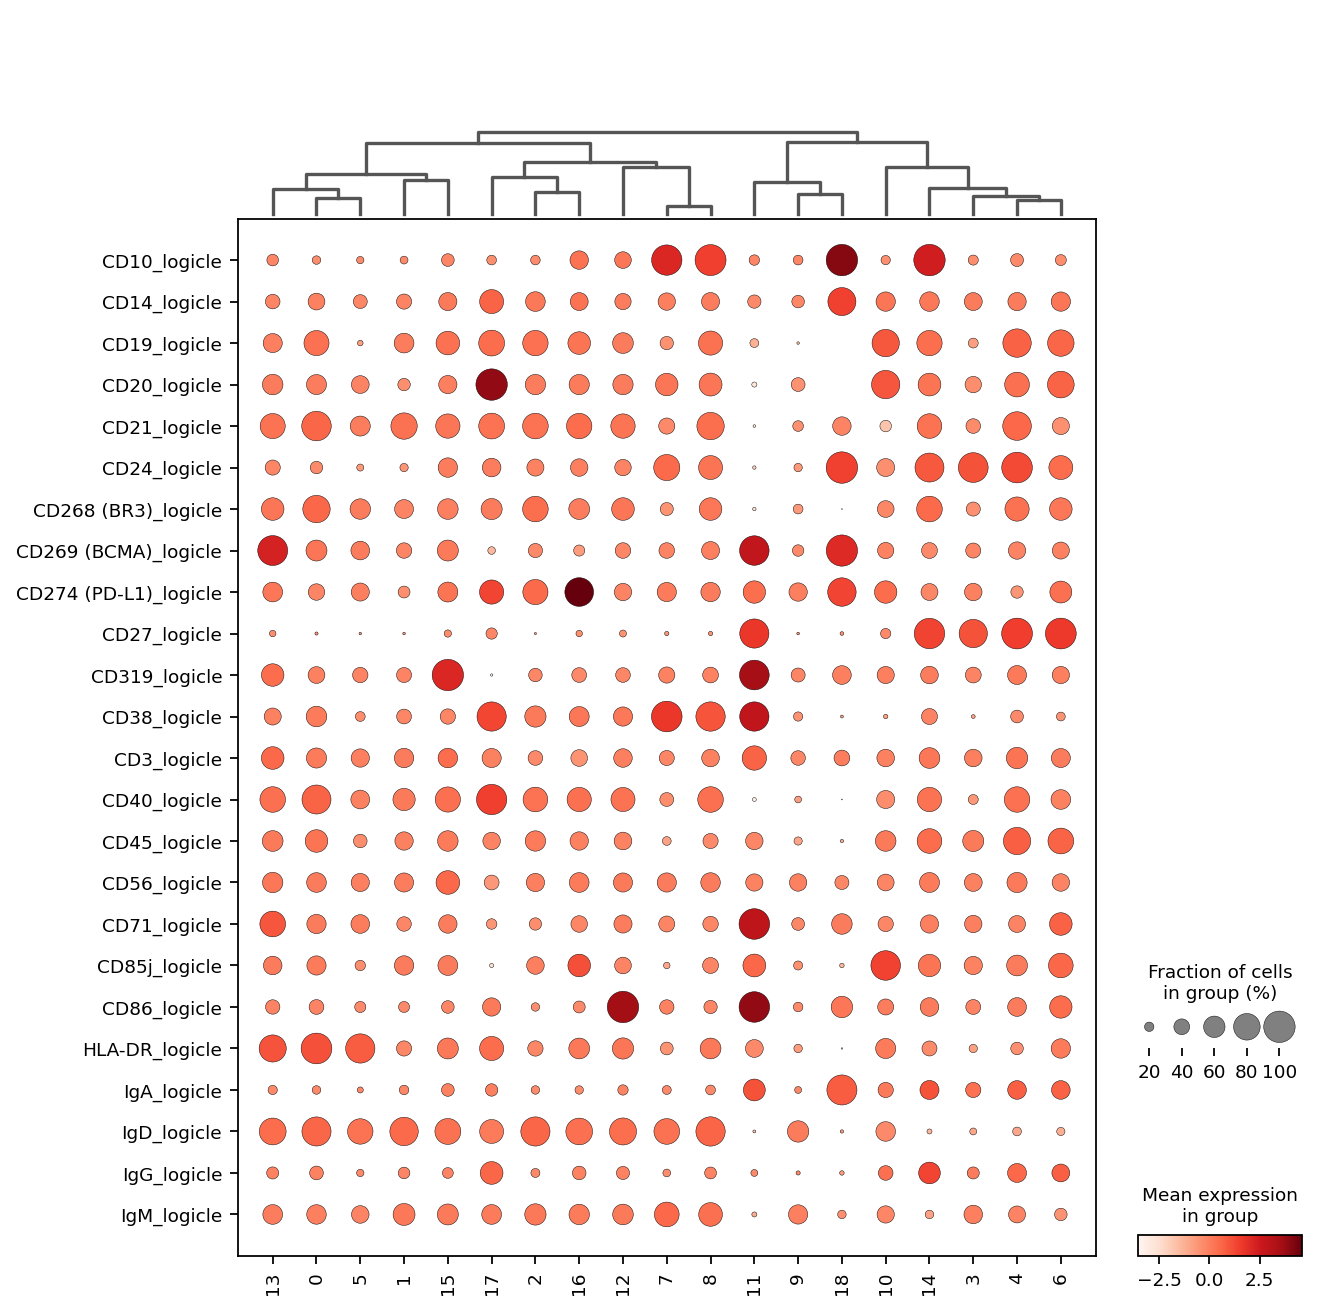

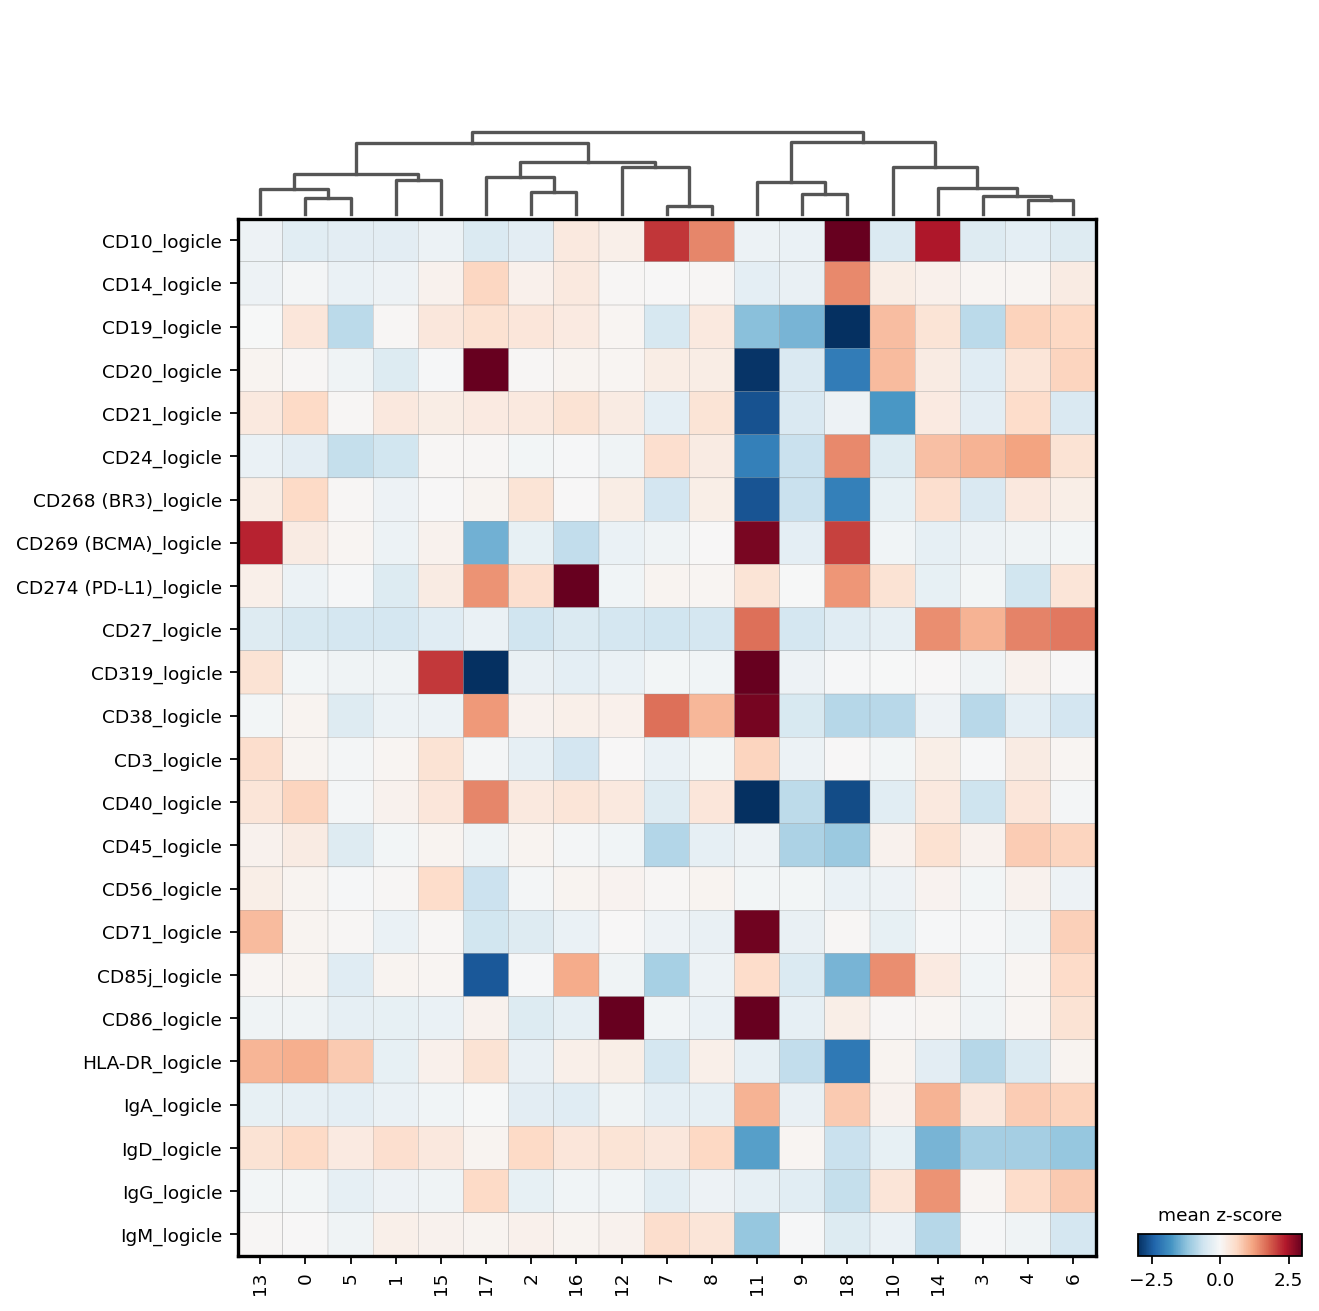

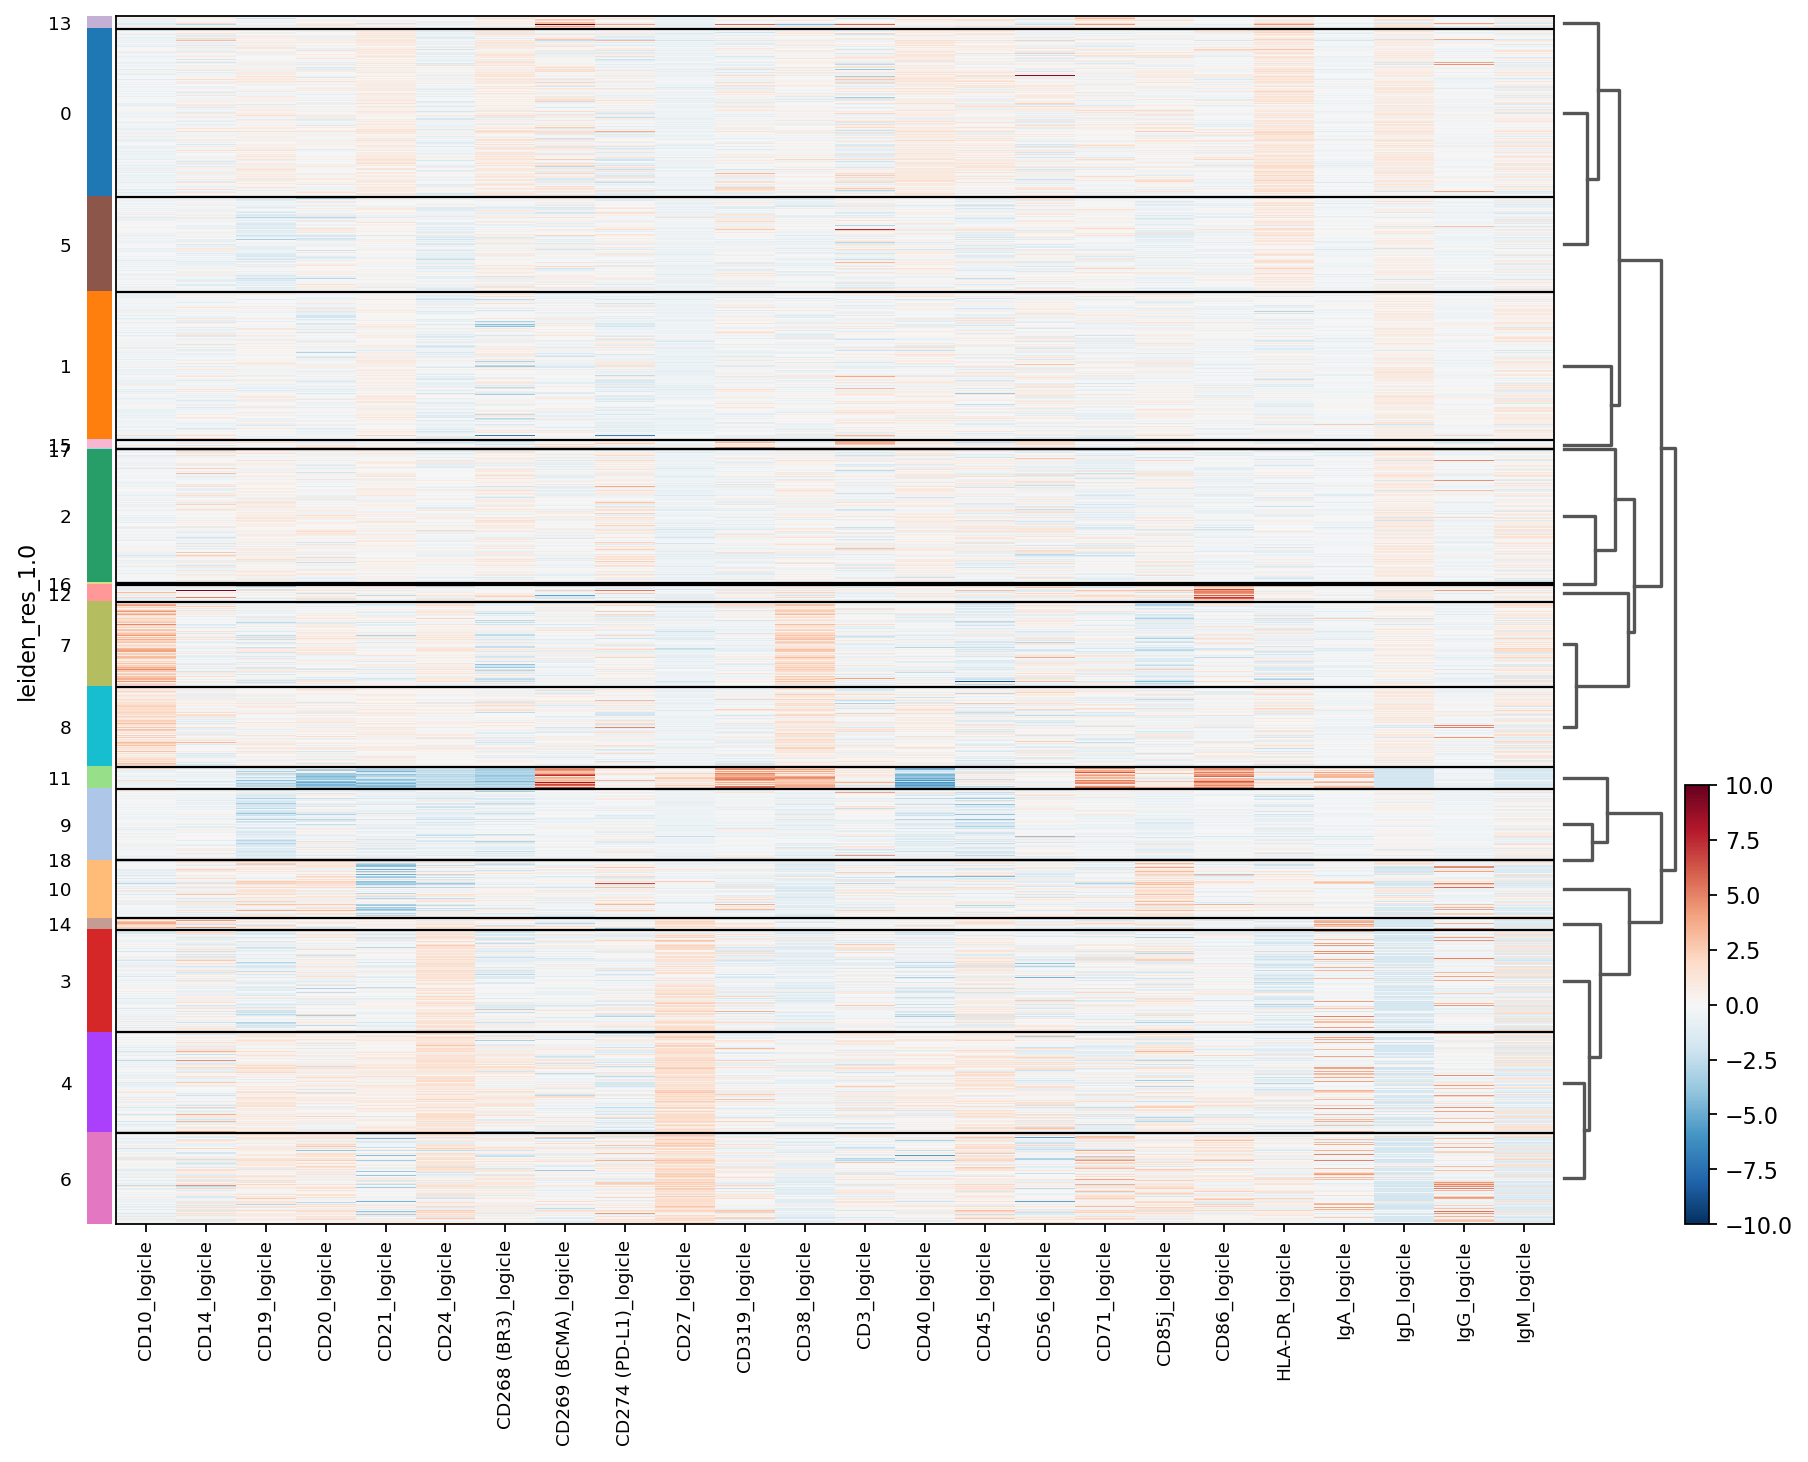

/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be chan

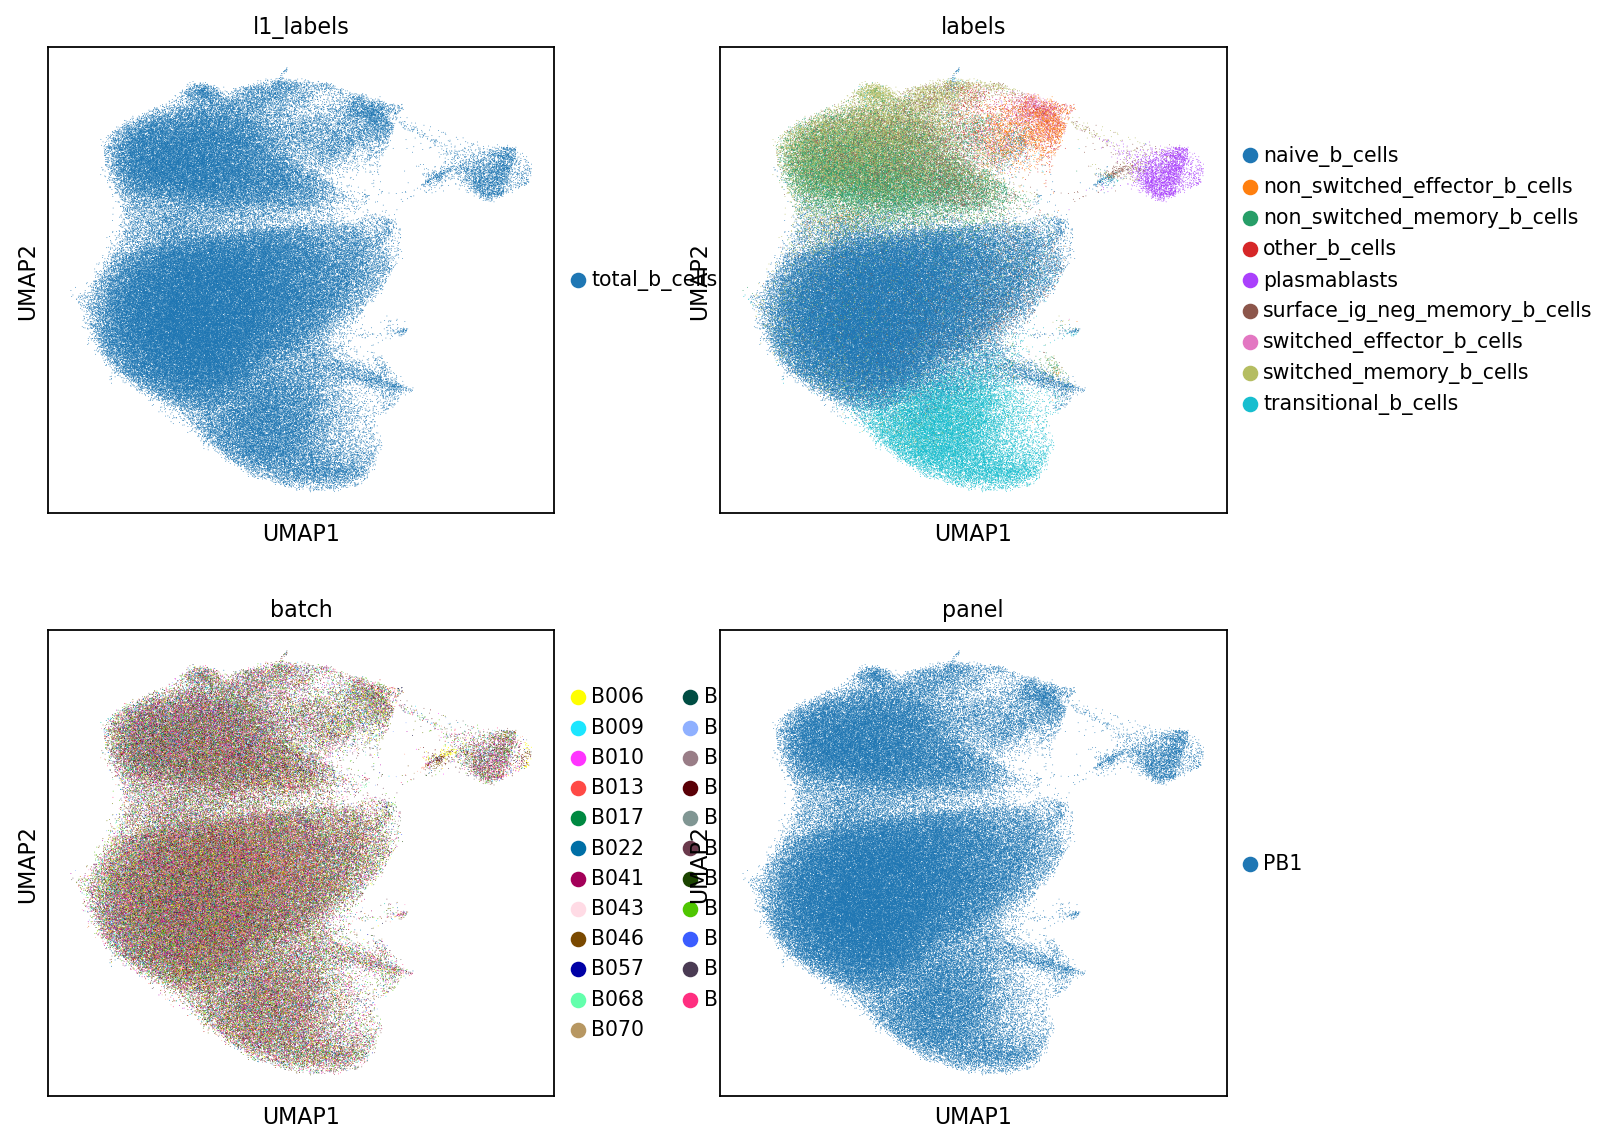

/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


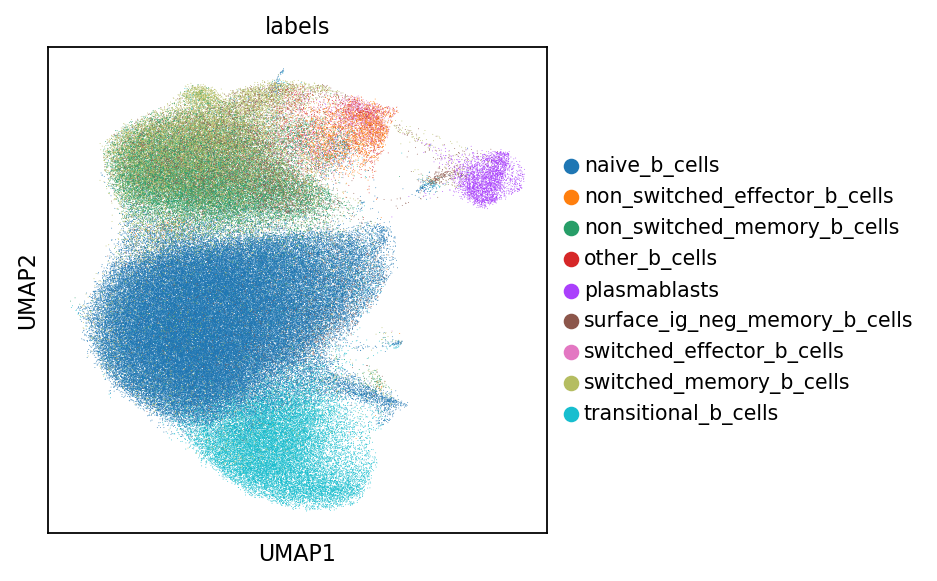

In [19]:
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    
    p1 = sc.pl.dotplot(sub_adata, sub_adata.var_names.sort_values(), leiden_res[label], dendrogram=True, swap_axes=True,return_fig=True, show=True)
    p1.savefig(fig_path  + label   + "_dotplot_exp_" + leiden_res[label] + "_" +panel + ".png",  dpi=400, bbox_inches='tight')

    p1 = sc.pl.matrixplot(sub_adata, sub_adata.var_names.sort_values(), leiden_res[label], dendrogram=True,colorbar_title='mean z-score', cmap='RdBu_r', swap_axes=True, vmin=-3, vmax=3, return_fig=True, show=True)
    p1.savefig(fig_path  + label   + "_avg_mean_heatmap_" + leiden_res[label] + "_" +panel + ".png",  dpi=400, bbox_inches='tight')

    sc.pl.heatmap(sub_adata, sub_adata.var_names.sort_values(), groupby=leiden_res[label], cmap='RdBu_r', dendrogram=True,show=True,figsize=(13,10), save= "_"+label   +"_cell_lvl_heatmap_" + leiden_res[label] + "_" +panel + ".png")

    p1=sy.plot.umap(sub_adata, color=['l1_labels','labels', 'batch','panel'], ncols =2, return_fig = True)
    p1.savefig(fig_path + label + "_umap_labels_batch_panel_"+ leiden_res[label] + "_" +panel + ".png",dpi=400, bbox_inches='tight')

    p1=sy.plot.umap(sub_adata, color=['labels'], return_fig = True)
    p1.savefig(fig_path + label + "_umap_l1_labels_"+ leiden_res[label] + "_" +panel + ".png",dpi=400, bbox_inches='tight')


    #p1 = sy.plot.umap(sub_adata, color= ['leiden_res_2', 'leiden_res_2.5', 'leiden_res_3', 'leiden_res_1.0'] ,return_fig = True, size = .5, ncols = 3)
    #p1.savefig(leiden_fig_path + label   + "_umap_leiden_resolutions_" + panel + ".png",  dpi=400, bbox_inches='tight')
    
    
    

/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


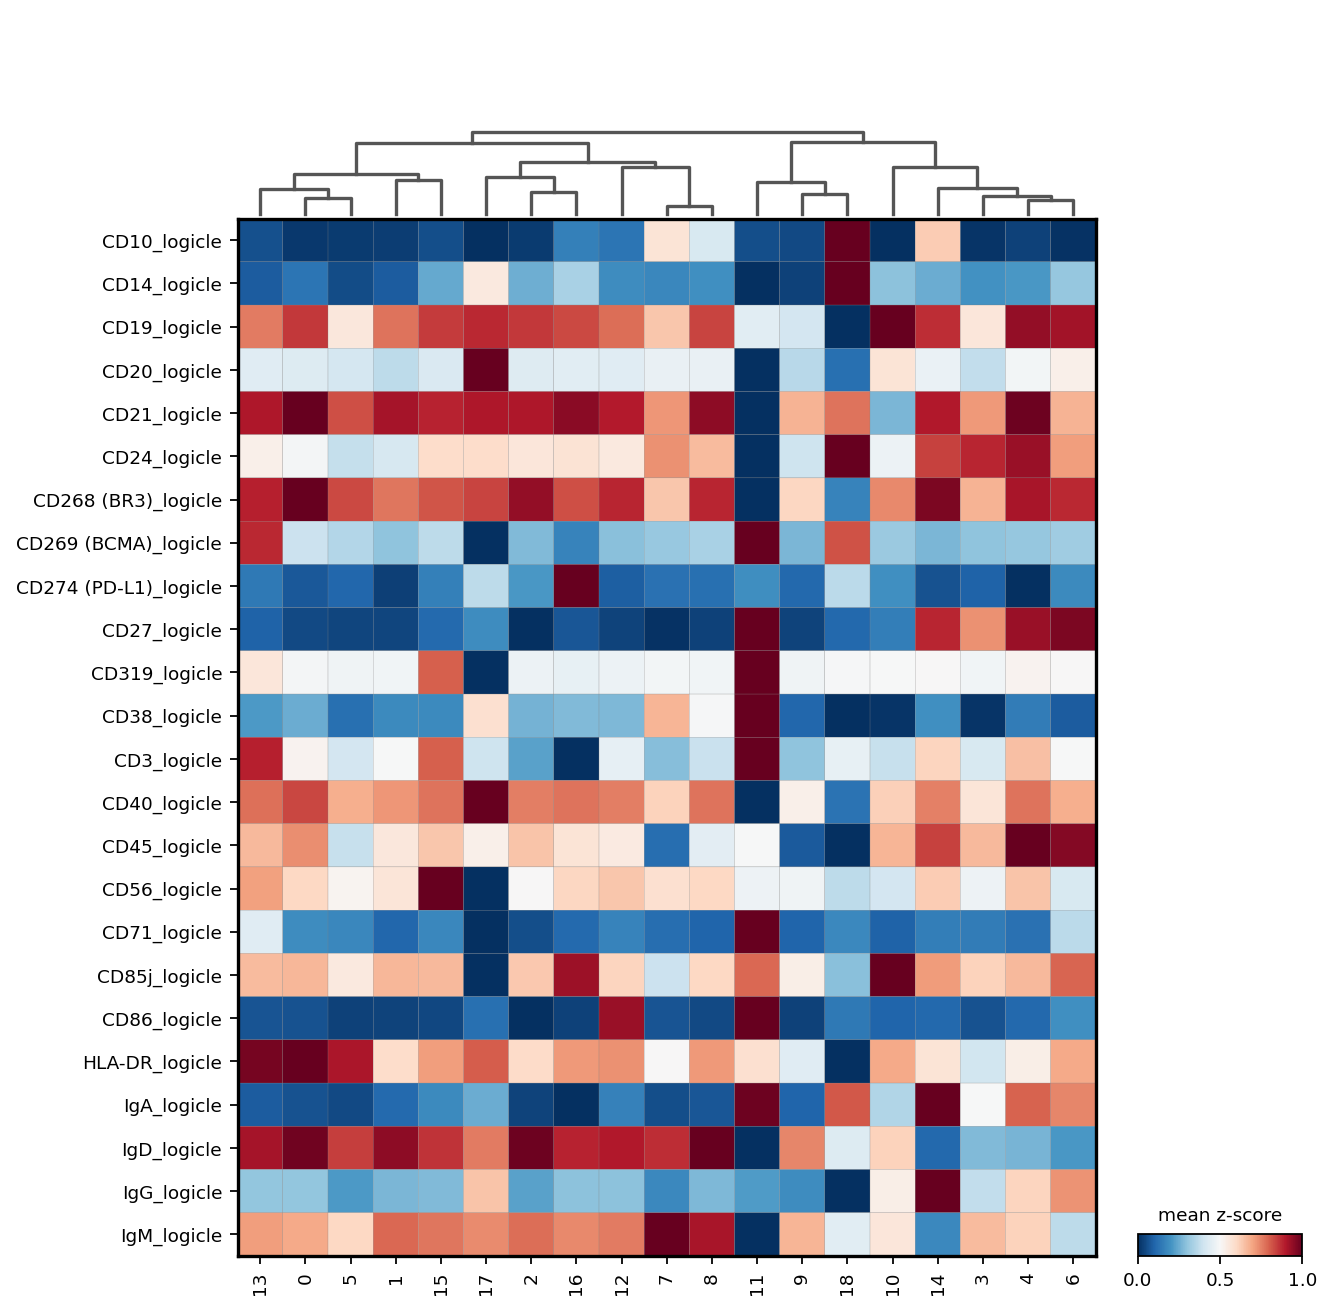

In [22]:
### add marker level rescaling to grouped mean heatmap

for label, sub_adata in adata_downsampled_celltypes.items():
    p1 = sc.pl.matrixplot(sub_adata, sub_adata.var_names.sort_values(), leiden_res[label],standard_scale='var', dendrogram=True,colorbar_title='mean z-score', cmap='RdBu_r', swap_axes=True, return_fig=True, show=True)

    p1.savefig(fig_path  + label   + "_avg_mean_heatmap_mak" + leiden_res[label] + "_" +panel + ".png",  dpi=400, bbox_inches='tight')


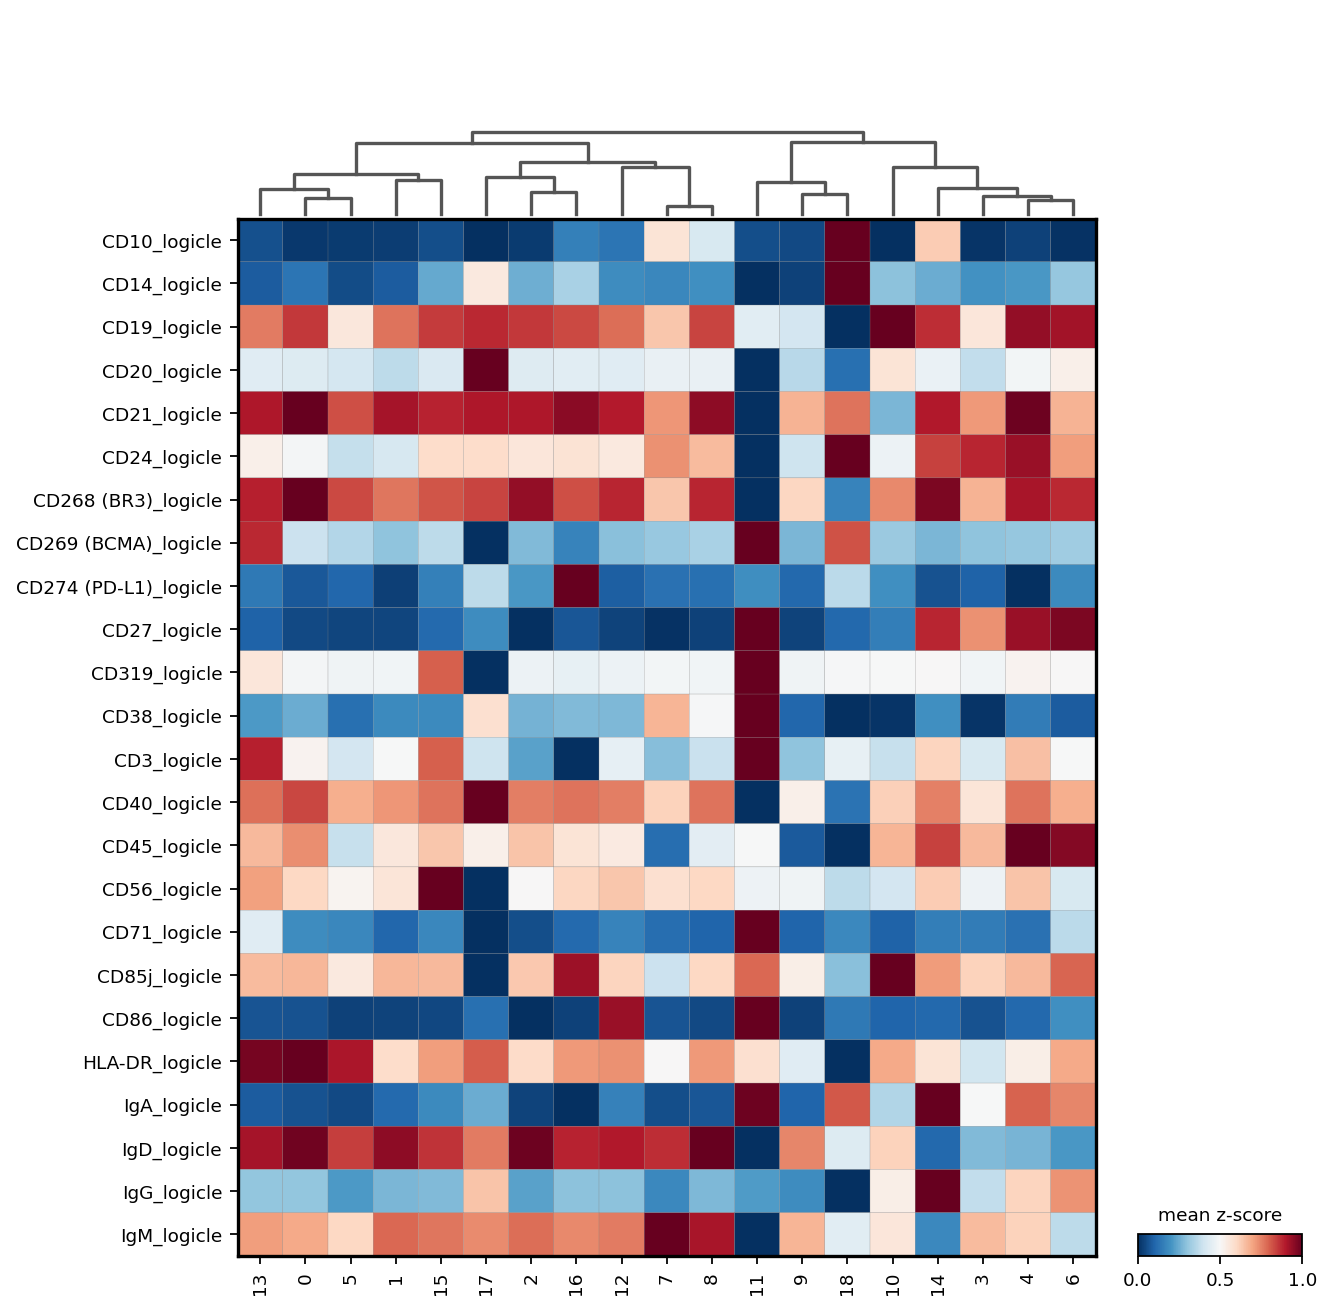

In [18]:
p1.show()